# Depth Prediction Example with StereoNet

In [1]:
import sys
import os
cwd = os.getcwd()
wd = os.path.join(cwd, "stereonet")
sys.path.append(wd)

In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from torch.utils.data import DataLoader
from models import StereoNet
from dataset import DepthEstDataset

In [3]:
model_name = "stereonet_IRS"
checkpt_path = "stereonet/checkpts/IRS.pth"
max_disp = 128
device = 'cuda'

### Load model from checkpoint

In [4]:
model = StereoNet(k=3, r=3, maxdisp=max_disp)
model.to(device)
checkpt = torch.load(checkpt_path)
model.load_state_dict(checkpt['state_dict'])

<All keys matched successfully>

### Predict depth from IRS images

In [5]:
data_path = "imgs/IRS"
l_img_path = os.path.join(data_path, "l_157.png")
r_img_path = os.path.join(data_path, "r_157.png")
disp_path = os.path.join(data_path, "d_157.exr")

l_img = Image.open(l_img_path).convert('RGB')
r_img = Image.open(r_img_path).convert('RGB')
disp = cv2.imread(disp_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
disp = disp[:,:,1]

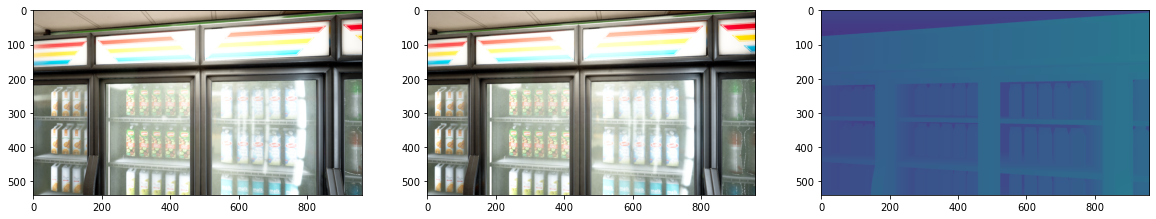

In [6]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(l_img)
plt.subplot(132)
plt.imshow(r_img)
plt.subplot(133)
plt.imshow(disp, vmin=0, vmax=max_disp)

In [7]:
l_img_tensor = transforms.ToTensor()(l_img)
r_img_tensor = transforms.ToTensor()(r_img)

l_img_tensor = torch.unsqueeze(l_img_tensor, dim=0)
r_img_tensor = torch.unsqueeze(r_img_tensor, dim=0)

l_img_tensor = l_img_tensor.to(device)
r_img_tensor = r_img_tensor.to(device)

with torch.no_grad():
    model.eval()
    outputs = model(l_img_tensor, r_img_tensor)
pred_disp = outputs[1].detach().cpu().numpy()
pred_disp = np.squeeze(pred_disp)

### Print prediction results and error metrics

In [8]:
pixel_num = disp.size
diff = np.abs(pred_disp - disp)
bad3 = diff > 3
bad3 = np.sum(bad3)
bad3 = bad3 / pixel_num * 100.0

epe = np.sum(diff)
epe = epe / pixel_num

print("Bad3 for model output: %.4f" % bad3)
print("EPE for model output: %.4f" % epe)

Bad3 for model output: 14.8927
EPE for model output: 1.7868


Text(0.5, 1.0, 'Pred Disp')

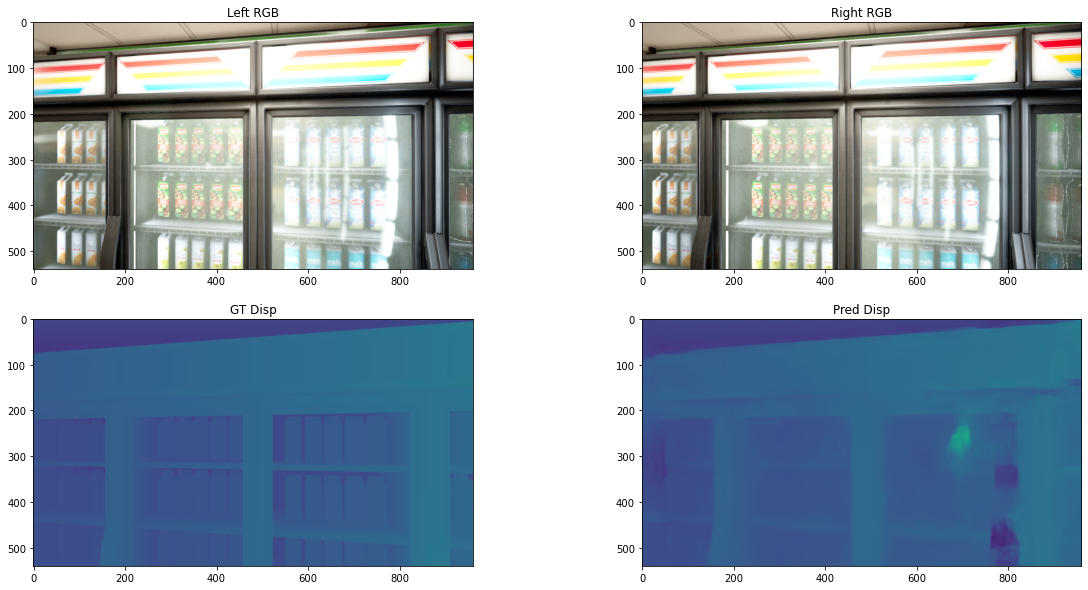

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(l_img)
plt.title("Left RGB")
plt.subplot(222)
plt.imshow(r_img)
plt.title("Right RGB")
plt.subplot(223)
plt.imshow(disp, vmin=0, vmax=max_disp)
plt.title("GT Disp")
plt.subplot(224)
plt.imshow(pred_disp, vmin=0, vmax=max_disp)
plt.title("Pred Disp")

### Print baseline (SGBM) and error metrics

In [10]:
stereo = cv2.StereoSGBM_create(numDisparities=max_disp, blockSize=7)
l_img_cv2 = cv2.imread(l_img_path)
r_img_cv2 = cv2.imread(r_img_path)
SGBM_disp = stereo.compute(l_img_cv2, r_img_cv2)
SGBM_disp = SGBM_disp / 16.0

In [11]:
pixel_num = disp[:, 128:].size
diff = np.abs(SGBM_disp[:, max_disp:] - disp[:, max_disp:])  # exclude the left x columns (x = max_disp)
bad3 = diff > 3
bad3 = np.sum(bad3)
bad3 = bad3 / pixel_num * 100.0

epe = np.sum(diff)
epe = epe / pixel_num

print("Bad3 for SGBM output: %.4f" % bad3)
print("EPE for SGBM output: %.4f" % epe)

Bad3 for SGBM output: 35.2301
EPE for SGBM output: 9.8464


Text(0.5, 1.0, 'SGBM Disp')

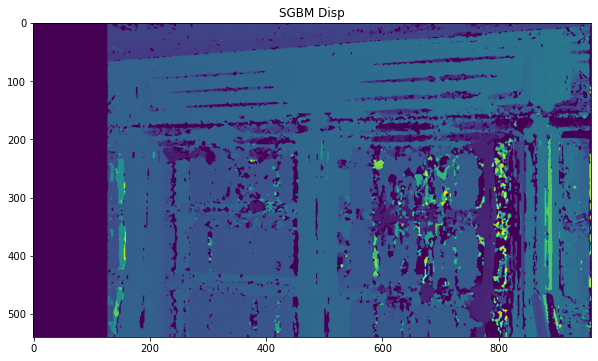

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(SGBM_disp, vmin=0, vmax=max_disp)
plt.title("SGBM Disp")

### Predict depth from D435 IR images

In [13]:
depth_dataset = DepthEstDataset(model_name)
test_loader = DataLoader(depth_dataset, batch_size=1, shuffle=True)

In [14]:
model.eval()
with torch.no_grad():
    for batch_id, inputs in enumerate(test_loader):
        left_im, right_im, pred_disp_path = inputs
        left_im = left_im.cuda()
        right_im = right_im.cuda()
        
        outputs = model(left_im, right_im)
        pred_disp = outputs[1].detach().cpu().numpy()
        pred_disp = np.squeeze(pred_disp)
        
        np.save(pred_disp_path[0], pred_disp)

In [15]:
left_im = torch.squeeze(left_im)
left_im = left_im.detach().cpu()
left_im = transforms.ToPILImage()(left_im)

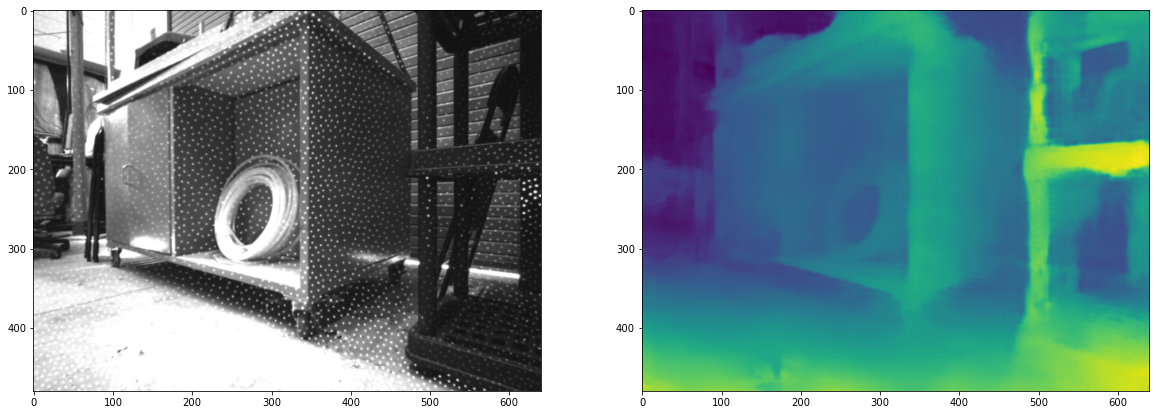

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(left_im)
plt.subplot(122)

pred_disp_for_plot = np.copy(pred_disp)
pred_disp_for_plot[pred_disp_for_plot>max_disp] = 0  # remove some outliers
pred_disp_for_plot = pred_disp_for_plot / np.amax(pred_disp_for_plot)
plt.imshow(pred_disp_for_plot)

### Error metrics for D435 data

In [17]:
data_path = "imgs"
gt_path = os.path.join(data_path, "gt_depth")
IRS_pred_path = os.path.join(data_path, "pred_depth", model_name)
# predicted results using the pretarined model from GitHub
orig_pred_path = os.path.join(data_path, "pred_depth", "stereonet") 
file_list = os.listdir(gt_path)
gt_file = []
IRS_pred_file=[]
orig_pred_file=[]
IRS_error = []
orig_error = []

In [18]:
def disp_to_depth(disp):
    BASELINE = 50.15/1000
    FOCAL_LENGTH = 385.88
    depth = BASELINE*FOCAL_LENGTH/disp
    depth = np.clip(depth, a_min=0, a_max=10)
    return depth

In [19]:
def depth_error(gt, pred):
    mask_min = gt > 0
    mask_max = gt <= 10
    mask = np.logical_and(mask_min, mask_max)
    total_pixels = np.sum(mask)
    l1 = np.abs(gt-pred)
    l1 = mask*l1
    l1 = np.sum(l1)/total_pixels
    
    ratio1 = (mask*pred)/gt
    ratio2 = gt / (mask*pred)
    ratio = np.maximum(ratio1, ratio2)
    a1 = ratio < 1.25
    a1 = np.sum(a1)/total_pixels*100
    return l1, a1

/home/xfan/Applications/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/xfan/Applications/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/xfan/Applications/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/xfan/Applications/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


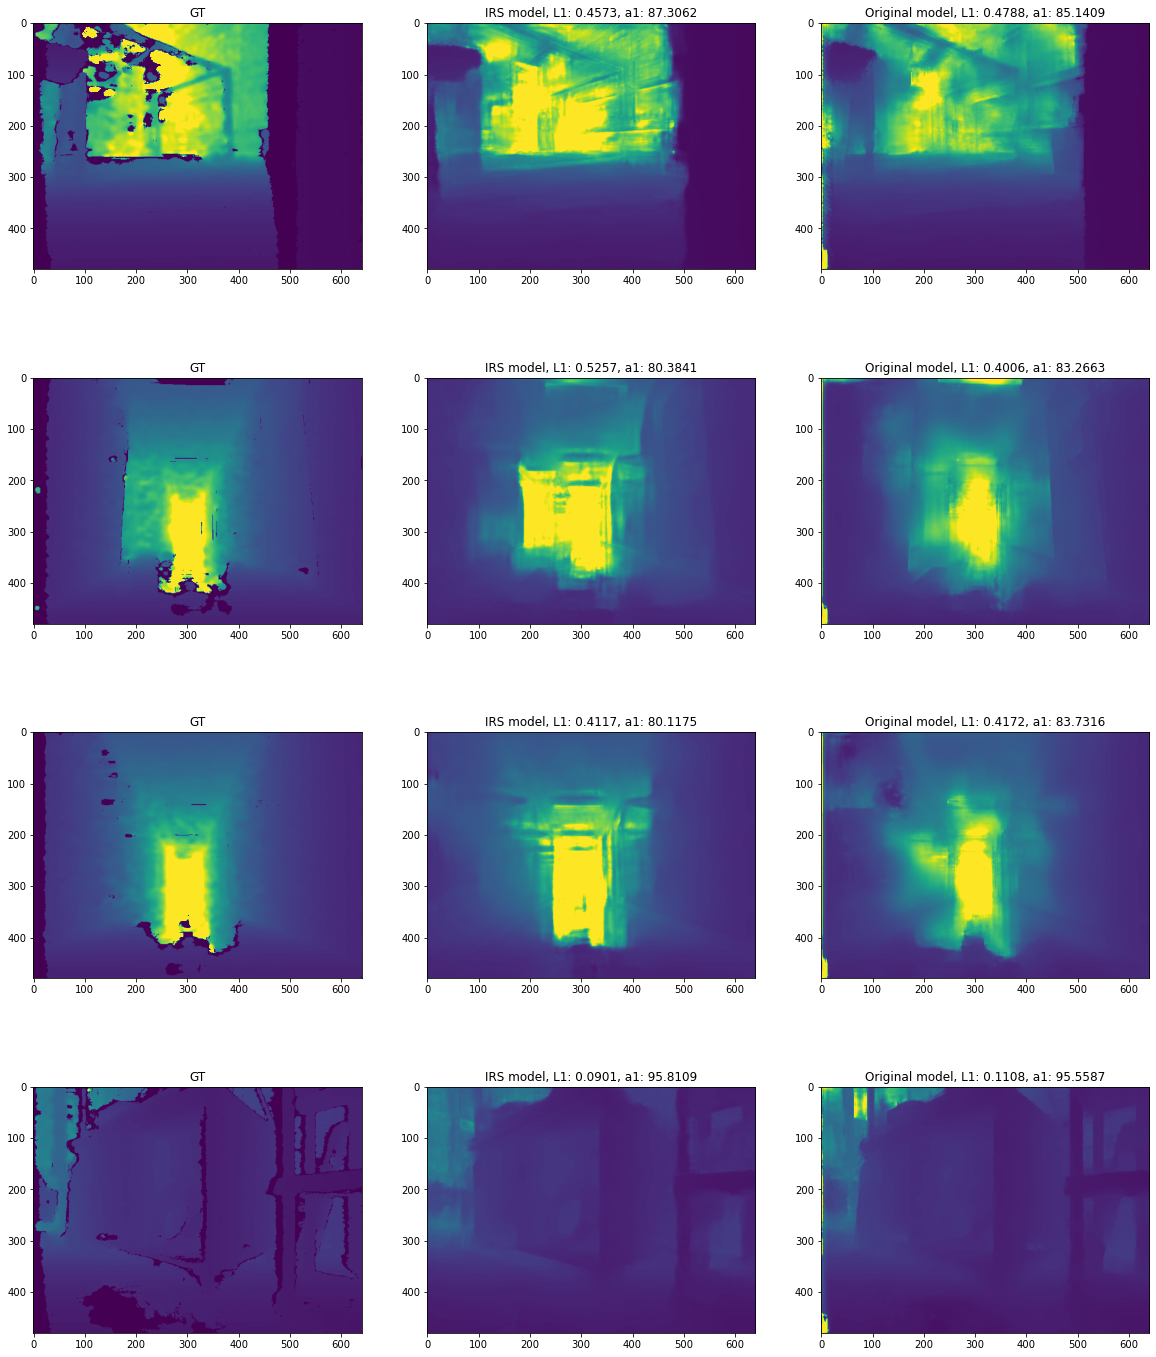

In [20]:
fig, axs = plt.subplots(4,3, figsize=(20, 25))
axs = axs.ravel()
i = 0
for f in file_list:
    frame_num = f.split('.')[0]
    gt_depth = np.genfromtxt(os.path.join(gt_path, f), delimiter=',')
    IRS_depth = np.load(os.path.join(IRS_pred_path, frame_num + ".npy"))
    IRS_depth = disp_to_depth(IRS_depth)
    orig_depth = np.load(os.path.join(orig_pred_path, frame_num + ".npy"))
    orig_depth = disp_to_depth(orig_depth)
    axs[i].imshow(gt_depth, vmin=0, vmax=10)
    axs[i].set_title("GT")
    axs[i+1].imshow(IRS_depth, vmin=0, vmax=10)
    l1, a1 = depth_error(gt_depth, IRS_depth)
    axs[i+1].set_title("IRS model, L1: %.4f, a1: %.4f" % (l1, a1))
    axs[i+2].imshow(orig_depth, vmin=0, vmax=10)
    l1, a1 = depth_error(gt_depth, orig_depth)
    axs[i+2].set_title("Original model, L1: %.4f, a1: %.4f" % (l1, a1))
    i += 3